In [1]:
# Step 0: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#  Step 1: Load Datasets

df1 = pd.read_csv("rwap25_gis_dataset1.csv")
df2 = pd.read_csv("rwap25_gis_dataset2.csv")

In [11]:
# 🔍 Step 2: Initial Data Quality Checks

print("Checking Dataset 1 (Assets)")
print(df1.info())
print(df1.isnull().sum().sort_values(ascending=False).head(10))
print("\n Checking Dataset 2 (ZIP-level Valuation)")
print(df2.info())

# Check for duplicate ZIP codes
print("Duplicates in ZIP valuation dataset:", df2["RegionName"].duplicated().sum())

# Check zero or negative square footage
print("Assets with 0 or negative rentable sq ft:", (df1["Building Rentable Square Feet"] <= 0).sum())

Checking Dataset 1 (Assets)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652 entries, 0 to 8651
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Location Code                               8652 non-null   object 
 1   Real Property Asset Name                    8652 non-null   object 
 2   Installation Name                           1262 non-null   object 
 3   Owned or Leased                             8652 non-null   object 
 4   GSA Region                                  8652 non-null   int64  
 5   Street Address                              8652 non-null   object 
 6   City                                        8652 non-null   object 
 7   State                                       8652 non-null   object 
 8   Zip Code                                    8652 non-null   int64  
 9   Latitude                                    8652 non-null

In [13]:
# 🛠️ Step 3: Clean and Prepare Data

# Rename ZIP column to prepare for merge
df2 = df2.rename(columns={"RegionName": "Zip Code"})

# Convert ZIP to string for clean merge
df1["Zip Code"] = df1["Zip Code"].astype(str)
df2["Zip Code"] = df2["Zip Code"].astype(str)

# Filter out rows with 0 or missing square footage
df1_clean = df1[df1["Building Rentable Square Feet"] > 0].copy()


Unique Asset Types: Real Property Asset Type
BUILDING     7818
STRUCTURE     166
Name: count, dtype: int64
Top 5 States by Asset Count:
 State
TX    806
CA    686
FL    378
VA    333
NY    315
Name: count, dtype: int64


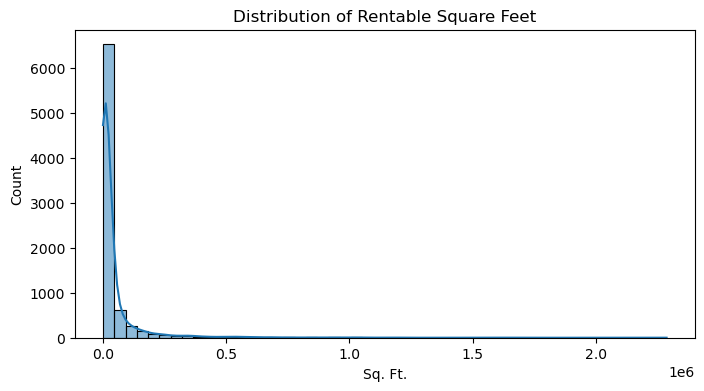

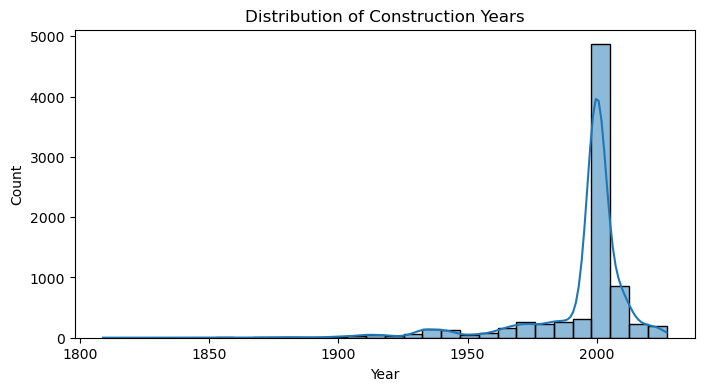

In [15]:
# 📊 Step 4: Exploratory Data Analysis (EDA)

print("Unique Asset Types:", df1_clean["Real Property Asset Type"].value_counts())
print("Top 5 States by Asset Count:\n", df1_clean["State"].value_counts().head())

# Distribution of Building Size
plt.figure(figsize=(8, 4))
sns.histplot(df1_clean["Building Rentable Square Feet"], bins=50, kde=True)
plt.title("Distribution of Rentable Square Feet")
plt.xlabel("Sq. Ft.")
plt.show()

# Construction Year Analysis
plt.figure(figsize=(8, 4))
sns.histplot(df1_clean["Construction Date"].dropna(), bins=30, kde=True)
plt.title("Distribution of Construction Years")
plt.xlabel("Year")
plt.show()


In [17]:
# 🔗 Step 5: Merge with ZIP Valuation

merged_df = pd.merge(
    df1_clean,
    df2[["Zip Code", "31-07-2025"]],
    on="Zip Code",
    how="left"
)

# Check unmatched ZIPs
unmatched = merged_df["31-07-2025"].isnull().sum()
print("Assets without ZIP-level valuation:", unmatched)


Assets without ZIP-level valuation: 538


In [19]:
# 💰 Step 6: Compute Estimated Asset Value

merged_df["Estimated Asset Value (USD)"] = (
    merged_df["Building Rentable Square Feet"] * merged_df["31-07-2025"]
)

# Flag missing valuations
merged_df["Missing Valuation"] = merged_df["Estimated Asset Value (USD)"].isnull()

In [21]:
# 📋 Step 7: Post-Merge Summary

print("Total assets with valid valuation:", (~merged_df["Missing Valuation"]).sum())
print("Total assets missing valuation:", (merged_df["Missing Valuation"]).sum())

# Top 10 most valuable assets
top_assets = merged_df.sort_values("Estimated Asset Value (USD)", ascending=False).head(10)
print("Top 10 Assets by Estimated Value:")
print(top_assets[[
    "Real Property Asset Name", "State", "City", 
    "Building Rentable Square Feet", "31-07-2025", "Estimated Asset Value (USD)"
]])

# Bottom 10 valuable assets
bottom_assets = merged_df[~merged_df["Missing Valuation"]].sort_values("Estimated Asset Value (USD)").head(10)


Total assets with valid valuation: 7446
Total assets missing valuation: 538
Top 10 Assets by Estimated Value:
        Real Property Asset Name State           City  \
3614  TED WEISS FEDERAL BUILDING    NY       NEW YORK   
1327      DANIEL P MOYNIHAN USCH    NY       NEW YORK   
6240         FEDERAL BLDG-201 VA    NY       NEW YORK   
7288      THURGOOD MARSHALL USCH    NY       NEW YORK   
313      CHET HOLIFIELD FED BLDG    CA  LAGUNA NIGUEL   
2791        500, 501,600 CARLYLE    VA     ALEXANDRIA   
7636  JOHN J. MOAKLEY COURTHOUSE    MA         BOSTON   
6379             REAGAN BLDG FOB    DC     WASHINGTON   
998         PHILLIP BURTON,FB CT    CA  SAN FRANCISCO   
1225      HERBERT C. HOOVER BLDG    DC     WASHINGTON   

      Building Rentable Square Feet    31-07-2025  Estimated Asset Value (USD)  
3614                      768646.22  3.018373e+06                 2.320061e+12  
1327                      684442.29  3.018373e+06                 2.065902e+12  
6240               

In [23]:
# 💾 Step 8: Save Final Dataset
merged_df.to_csv("cleaned_asset_valuation.csv", index=False)
print("Saved: cleaned_asset_valuation.csv")

Saved: cleaned_asset_valuation.csv


In [29]:
!pip install streamlit streamlit-folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [streamlit-folium]


TASK 3 - MACHINE LEARNING MODEL

In [34]:
# --------------------------------------------------------------------------
# Task 3: Machine Learning Models
# --------------------------------------------------------------------------

# Step 1: Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Load the cleaned dataset
df_ml = pd.read_csv("cleaned_asset_valuation.csv")

--- Part 1: Unsupervised Learning (Clustering) ---


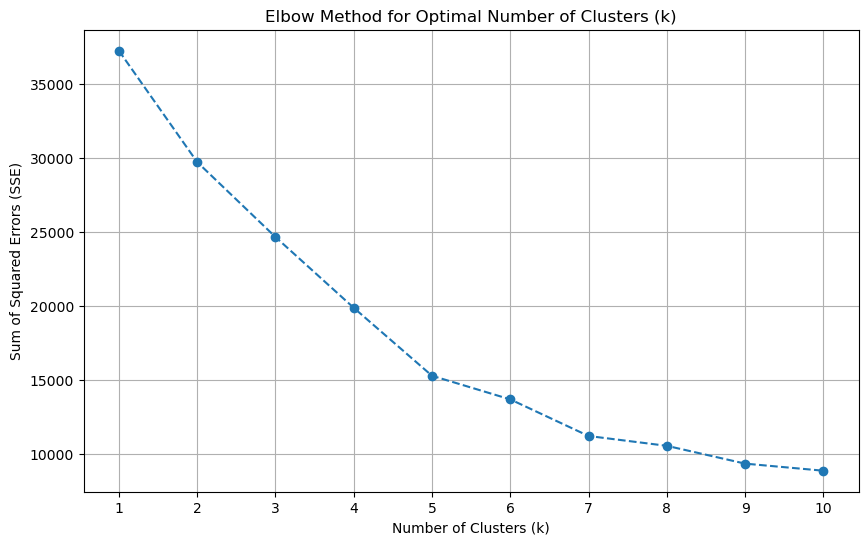

\nSelected optimal number of clusters: 4
\nAsset Class Distribution:
Asset Class
0    3469
3    2524
1    1265
2     188
Name: count, dtype: int64


In [36]:
# Part 1: Unsupervised Learning - Creating Asset Classes with K-Means
# --------------------------------------------------------------------------
print("--- Part 1: Unsupervised Learning (Clustering) ---")

# Select numerical features for clustering
features = ['Building Rentable Square Feet', 'Construction Date', 'Latitude', 'Longitude', 'Estimated Asset Value (USD)']

# Create a new DataFrame and drop rows with missing values in these key features
df_cluster = df_ml.dropna(subset=features).copy()

# Scale the features to ensure they have equal importance
# This is crucial for distance-based algorithms like K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# --- Determine the optimal number of clusters using the Elbow Method ---
sse = [] # Sum of Squared Errors
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, k=4 appears to be a good choice.
optimal_k = 4
print(f"\\nSelected optimal number of clusters: {optimal_k}")

# Train the final K-Means model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
# Create a new 'Asset Class' column with the cluster labels
df_cluster['Asset Class'] = kmeans.fit_predict(X_scaled)

print("\\nAsset Class Distribution:")
print(df_cluster['Asset Class'].value_counts())


In [38]:
# Part 2: Supervised Learning - Predicting Asset Classes
# --------------------------------------------------------------------------
print("\\n--- Part 2: Supervised Learning (Classification) ---")

# Define our features (X) and the target we want to predict (y)
X = df_cluster[features]
y = df_cluster['Asset Class']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the unseen test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\\nModel Accuracy: {accuracy:.2f}")
print("\\nClassification Report:")
print(classification_report(y_test, y_pred))


\n--- Part 2: Supervised Learning (Classification) ---
\nModel Accuracy: 0.98
\nClassification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1041
           1       0.98      0.99      0.98       380
           2       0.95      0.96      0.96        56
           3       0.99      0.98      0.98       757

    accuracy                           0.98      2234
   macro avg       0.98      0.98      0.98      2234
weighted avg       0.98      0.98      0.98      2234

